Aims:
1. Finalizing data processing/cleaning function.
2. Explortatory Data Analysis (EDA)

Before heading into EDA, data processing function needs 
to be modified for negation, url link structure variability,
and Twitter ID variability.

Negation words are split into two parts. The 't' after the apostrophe vanishes 
when I filtethe r tokens with length >1 syllable. This means "can't" = "can".

Some of the URL links don't start with "http" as initially assumed. Some people paste 
"www.aaa.com" as a link. Also, another fix is to add symbols such as "=", "_", "~", 
etc. to URL editor.

Lastly, Twitter ID's are modified further to include underscore symbol as character
that can be used with ID. 

Updated cleaning function in the following order:
    
1. Souping
2. BOM removing
3. url address('http:'pattern), twitter ID removing
4. url address('www.'pattern) removing
5. lower-case
6. negation handling
7. removing numbers and special char's
8. tokenizing and joining

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # Two lines above, during the letters_only process, unnecessay white spaces were created.
    # To remove these white space, tokenize and join together.
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [4]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv",header=None,usecols=[0,5],names=['sentiment','text'])
df['sentiment'] = df['sentiment'].map({0:0, 4:1})
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [5]:
%%time
print "Cleaning the tweets...\n"
clean_tweets_texts = []
for i in xrange(0, len(df)):
    if( (i+1)%100000 == 0 ):
        print "Tweets %d of %d has been processed" % (i+1, len(df) )
    clean_tweets_texts.append(tweet_cleaner_updated(df['text'][i]))

Cleaning the tweets...



/Users/mindyng/anaconda/lib/python2.7/encodings/utf_8_sig.py:19: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if input[:3] == codecs.BOM_UTF8:


Tweets 100000 of 1600000 has been processed
Tweets 200000 of 1600000 has been processed
Tweets 300000 of 1600000 has been processed
Tweets 400000 of 1600000 has been processed
Tweets 500000 of 1600000 has been processed
Tweets 600000 of 1600000 has been processed
Tweets 700000 of 1600000 has been processed
Tweets 800000 of 1600000 has been processed
Tweets 900000 of 1600000 has been processed
Tweets 1000000 of 1600000 has been processed
Tweets 1100000 of 1600000 has been processed
Tweets 1200000 of 1600000 has been processed
Tweets 1300000 of 1600000 has been processed
Tweets 1400000 of 1600000 has been processed
Tweets 1500000 of 1600000 has been processed
Tweets 1600000 of 1600000 has been processed
CPU times: user 11min 25s, sys: 33.9 s, total: 11min 59s
Wall time: 12min 2s


In [6]:
clean_df = pd.DataFrame(clean_tweets_texts, columns = ['text'])
clean_df['target'] = df.sentiment
clean_df.to_csv('clean_tweet.csv', encoding = 'utf-8')

In [7]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv, index_col = 0)
my_df.head()

/Users/mindyng/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


After re-cleaning the data/text with the new function, took another exploratory round with the 
newly cleaned text.

In [8]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
text      1596019 non-null object
target    1600000 non-null int64
dtypes: int64(1), object(1)
memory usage: 36.6+ MB


In [9]:
my_df[my_df.isnull().any(axis=1)].head()

,text,target
208,NaN,0
249,NaN,0
282,NaN,0
398,NaN,0
430,NaN,0


In [10]:
np.sum(my_df.isnull().any(axis=1))

3981

In [11]:
my_df.isnull().any(axis=0)

text       True
target    False
dtype: bool

It appears there are a total of 3981 null entries post text-processing. However, at the beginning, prior to cleaning the text, there were no null values. The null values must have 
appeared during cleaning text procedure.

In [13]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", header = None)
df.iloc[my_df[my_df.isnull().any(axis=1)].index,:].head()

,0,1,2,3,4,5
208,0,1467863072,Mon Apr 06 22:33:25 PDT 2009,NO_QUERY,Artiel87,@mandayyy
249,0,1467874569,Mon Apr 06 22:36:27 PDT 2009,NO_QUERY,Artiel87,@mandayyy
282,0,1467881474,Mon Apr 06 22:38:20 PDT 2009,NO_QUERY,__Susan__,@ITS_NEMESIS -------
398,0,1467912842,Mon Apr 06 22:46:53 PDT 2009,NO_QUERY,KimberlyKane,@danadearmond
430,0,1467919452,Mon Apr 06 22:48:48 PDT 2009,NO_QUERY,jtmal0723,@anistorm


By looking at the original data, can see that only text was either user id or possibly URL address. Regardless of where these values came from, all null rows will be dropped.

In [14]:
my_df.dropna(inplace = True)
my_df.reset_index(drop= True, inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596019 entries, 0 to 1596018
Data columns (total 2 columns):
text      1596019 non-null object
target    1596019 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


**Word Cloud**

A Word cloud is a bunch of words that vary in size dependent upon word's frequency. There is
some heated debate over it because some people say that Word Cloud is a crudy way of examining
body of text. 

In [15]:
neg_tweets = my_df[my_df.target == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

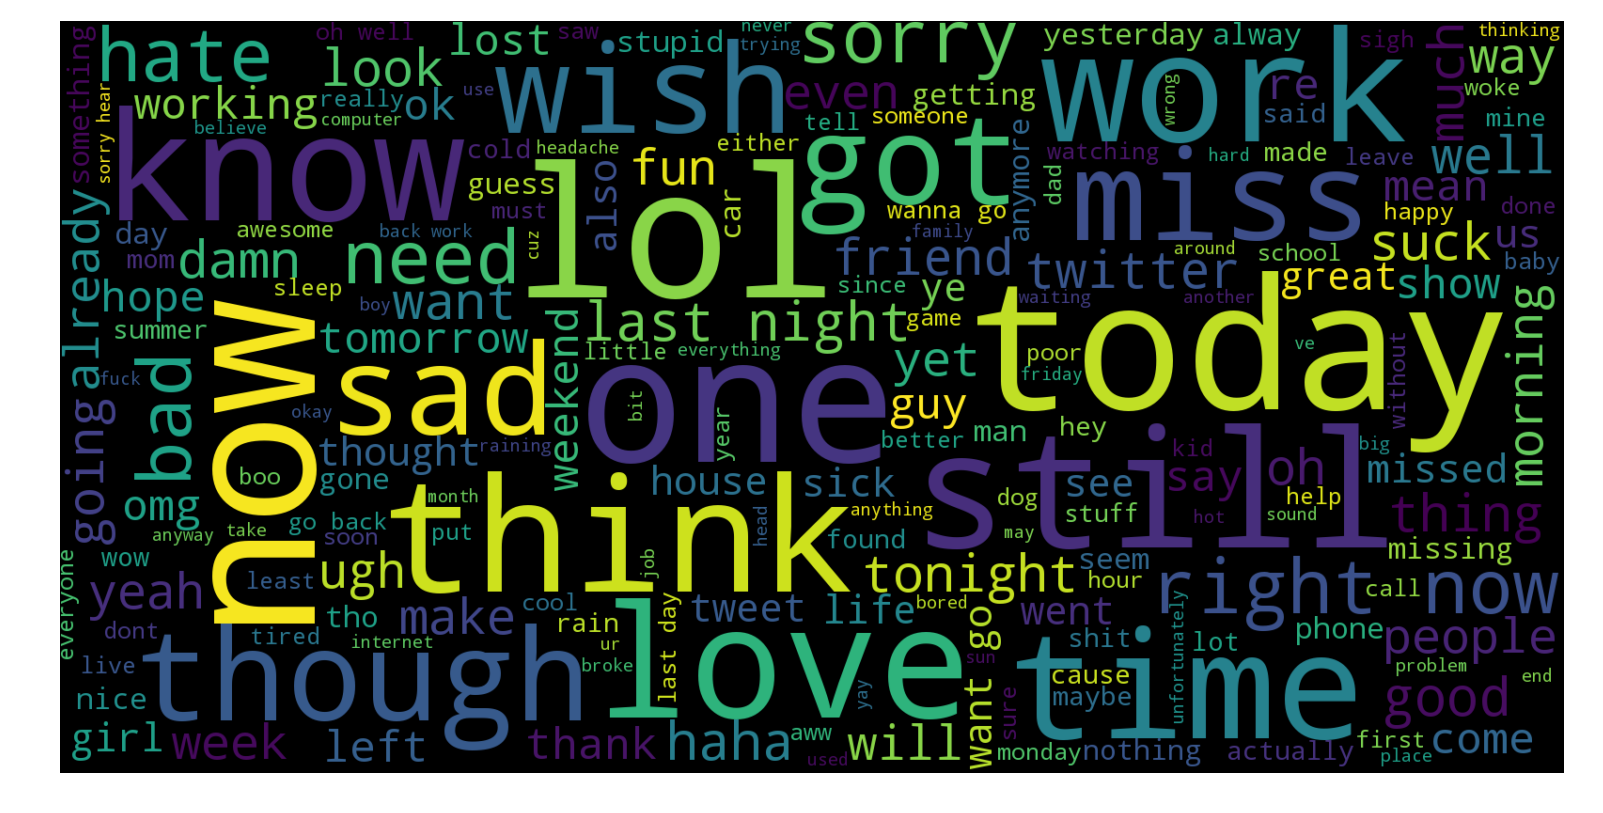

In [16]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Not surprisingly that many of the most frequent words are neutral, such as, "today", "though", "now", "time" and "one". Most of the big words are obviously negative such as "sad", "hate", "sorry", "suck". However, the word "love" is huge as well, but it is not a negative sentiment. Let us explore this a little closer.

In [17]:
for t in neg_tweets.text[:200]:
    if 'love' in t:
        print t

ahh ive always wanted to see rent love the soundtrack
meh almost lover is the exception this track gets me depressed every time
awe love you too am here miss you
damn the grind is inspirational and saddening at the same time do not want you to stop cuz like what do much love
missing you babe but as long as your alive happy ya tired my love imma try to sleep hopefully you had headstart
love the french tell people here in the south qtr french and they snarl at me french are beautiful people


It turns out the word "love" is mixed in with negative words that produce overall negative sentiment. Also, sarcasm causes positive words to be mixed with negative words.

In [18]:
pos_tweets = my_df[my_df.target == 1]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

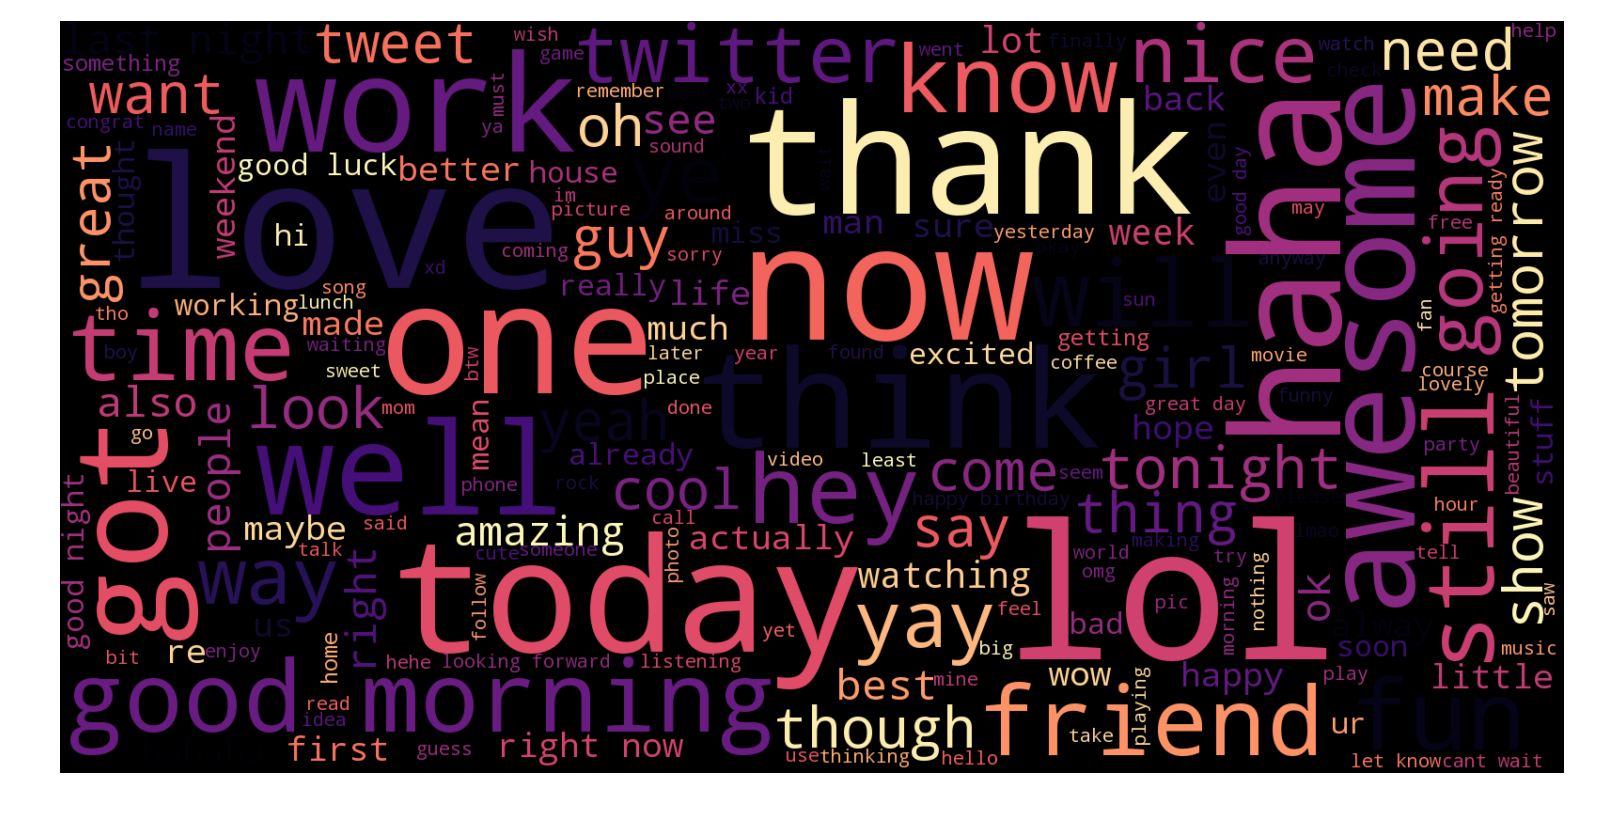

In [19]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Neutral words such as "one", "now", "still" appear frequently again. However, positive words, such as "love", "lol", "haha" appear as expected to express positive sentiment. An interesting observation is that "work" is seen as a frequently in negative and positive sentiments. So people see work as negative or positive. Not suprising either. 

In [20]:
del pos_tweets, pos_string, neg_tweets, neg_string, wordcloud, df

**Preparation for Data Viz**

In order to implement some data viz, need term frequency data. What sort of words are in the corpus and how often do they appear? Count vectorizer was used to answer these questions. It calculates term frequencies. The count vectorizer is also for fitting and predicting, but for now, the focus will be on extracting term frequencies.

When using count vectorizer, there are parameter options to use that can eliminate stop words and put a limit on maximum number of terms. These parameters will not be used at this moment in order to get a full picture of the dataset without any modifications. Therefore, count vectorizer is implemented with stop words included and without a limit on maximum number of terms.

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(my_df.text)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [22]:
len(cvec.get_feature_names())

264936

Count vectorizer came up with 264936 words in the corpus. 

In [23]:
neg_doc_matrix = cvec.transform(my_df[my_df.target == 0].text)
pos_doc_matrix = cvec.transform(my_df[my_df.target == 1].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()

Got term frequency via transforming sparse matrix to a dense one.